####Gaurav Phatkare - AI/ML Developer Itern : Assessment Test

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

In [ ]:
df = pd.read_excel('/content/AI Prediction.xlsx', index_col="Date")

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1095 entries, 2020-04-01 to 2018-03-31
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   energydemand     1095 non-null   int64  
 1   min temparature  1095 non-null   float64
 2   max temparature  1095 non-null   float64
dtypes: float64(2), int64(1)
memory usage: 34.2 KB


In [ ]:
df.describe()

,energydemand,min temparature,max temparature
count,1095.000000,1095.000000,1095.000000
mean,8192.705936,24.095699,33.710804
std,783.126091,2.991502,3.090391
min,5826.000000,14.780000,23.780000
25%,7612.000000,21.975000,31.155000
50%,8230.000000,24.770000,33.510000
75%,8724.000000,26.185000,35.905000
max,10207.000000,29.670000,42.280000


In [ ]:
df.duplicated().sum()

0

In [ ]:
df.columns

Index(['energydemand', 'min temparature', 'max temparature'], dtype='object')

In [ ]:
#dataset is not in sorted order
df = df.sort_index()

##EDA

Text(0, 0.5, 'Energy Consumption')

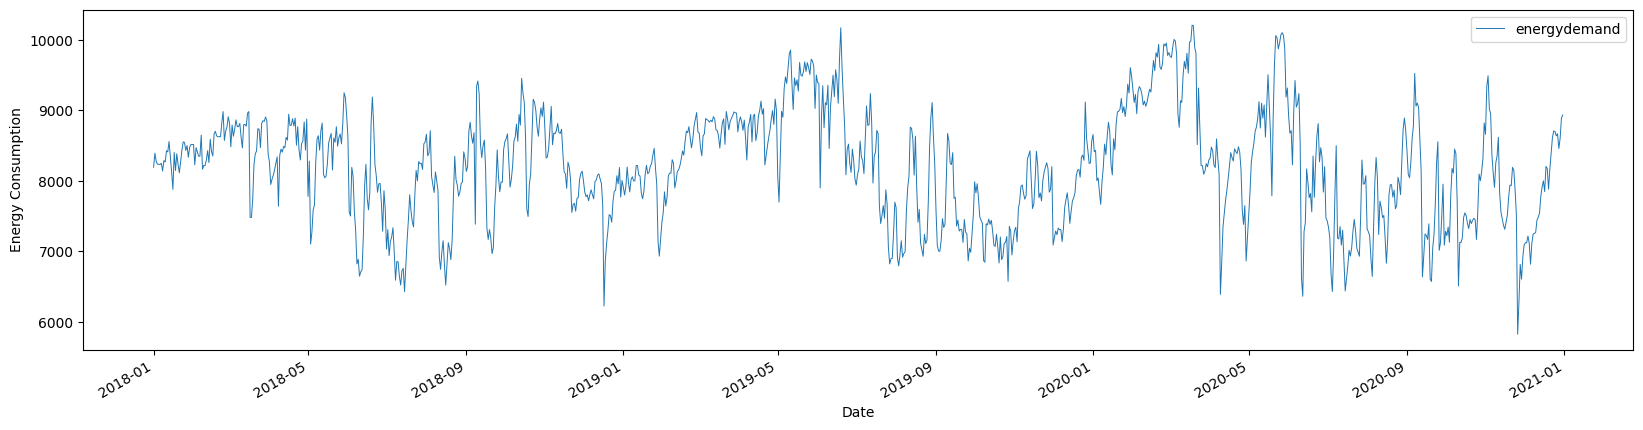

In [ ]:
pd.DataFrame(df["energydemand"]).plot(figsize=(20, 5),linewidth=0.7)
plt.ylabel("Energy Consumption")

<Axes: xlabel='Date'>

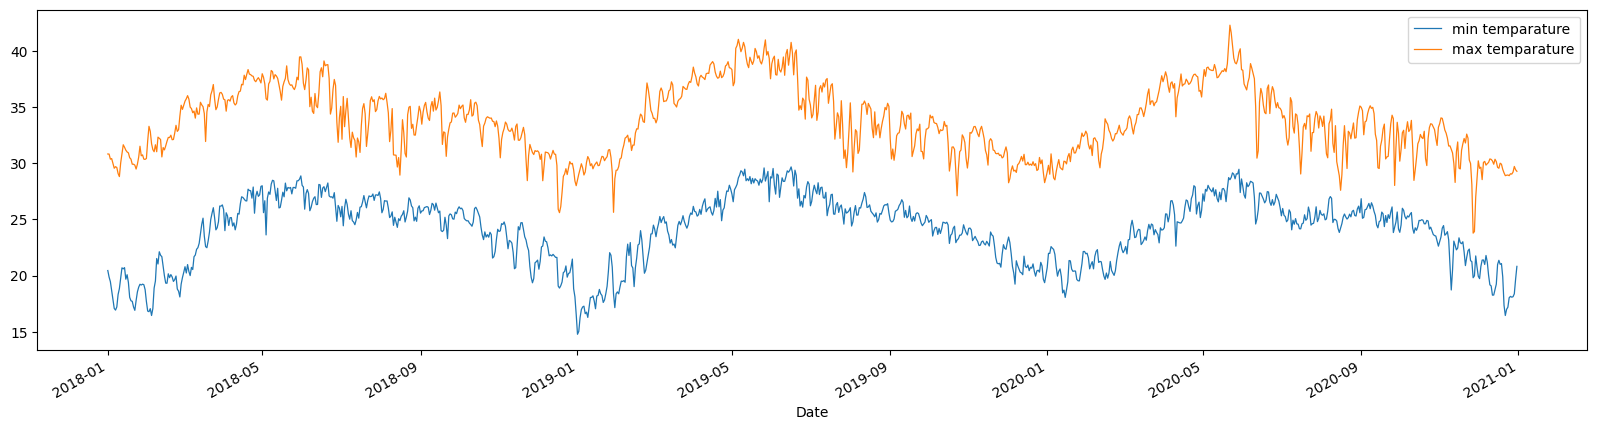

In [ ]:
df[['min temparature', 'max temparature']].plot(figsize=(20, 5), linewidth=0.9)

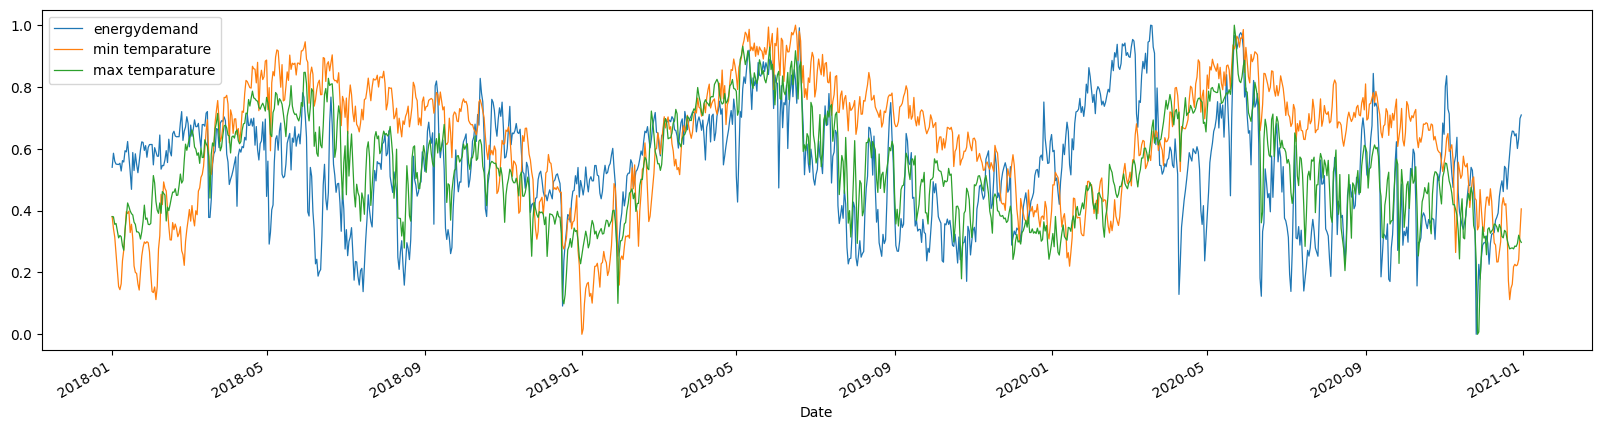

In [ ]:
from sklearn.preprocessing import minmax_scale
scaled_energy_df = pd.DataFrame(minmax_scale(df[['energydemand', 'min temparature', 'max temparature']]), columns=df.columns, index=df.index)
scaled_energy_df.plot(figsize=(20, 5), linewidth=0.9);

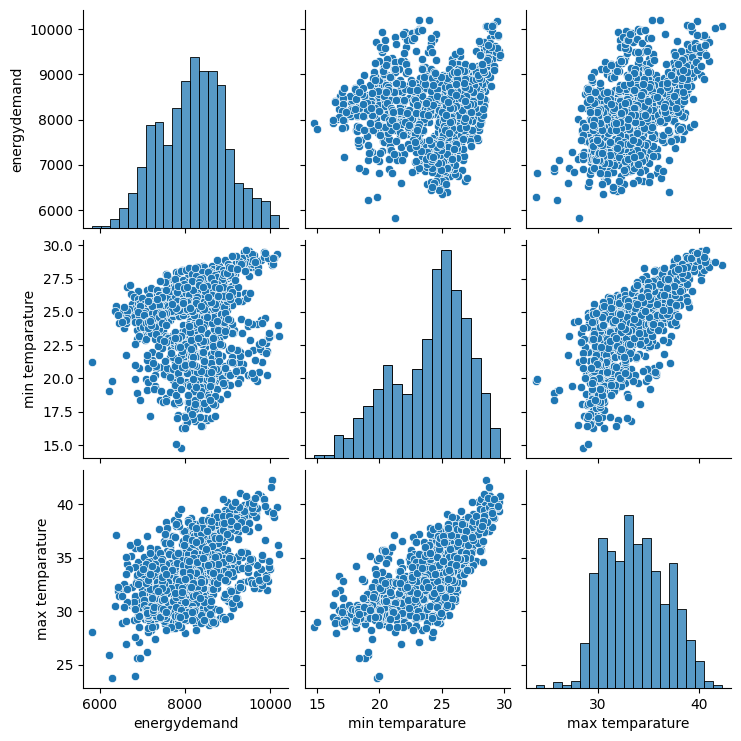

In [ ]:
sns.pairplot(df)

In [ ]:
#explicitly put 30 days data for testing
test_samples = 30
train_df = df.iloc[:len(df) - test_samples]
test_df = df.iloc[len(df) - test_samples:]

In [ ]:
train_df.shape, test_df.shape

((1065, 3), (30, 3))

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scalar = MinMaxScaler(feature_range=(0, 1))
scaled_df = scalar.fit_transform(train_df.to_numpy())
scaled_df = pd.DataFrame(scaled_df, columns = list(train_df.columns))


In [ ]:
scaled_df.head()

,energydemand,min temparature,max temparature
0,0.540288,0.380792,0.380541
1,0.585711,0.341840,0.380000
2,0.559690,0.314305,0.355676
3,0.550559,0.261921,0.358378
4,0.549190,0.154466,0.311892


In [ ]:
output_scalar = MinMaxScaler(feature_range=(0, 1))
scaled_df[["energydemand"]] = output_scalar.fit_transform(train_df[['energydemand']].to_numpy())

Now there are 2..3 approaches we can use to tackle problem statement

first try with window , horizon technique

window means number of past timestamps going to consider for prediction of future n number of horizon

In [ ]:
# first set horizon = 1 and window size will be 10 ..and predict 1 output based on previous 10 observations
WINDOW_SIZE = 10
HORIZON = 1

In [ ]:
def window_maker(df, window):
  sequence = []
  labels = []

  for i in range(0, len(df) - window):
    res = []

    for j in range(0, window):
      r = []
      for col in df.columns:
        r.append(df[col][i + j])
      res.append(r)
    sequence.append(res)
    labels.append(df["energydemand"][i + window])

  return np.array(sequence), np.array(labels)

In [ ]:
sequence, labels = window_maker(scaled_df, WINDOW_SIZE)

In [ ]:
sequence.shape, labels.shape

((1055, 10, 3), (1055,))

In [ ]:
# function for evaluating metrics
def maseFunc(y_true, y_pred):

  mae = tf.reduce_mean(tf.abs(y_true - y_pred))


  mae_naive_no_season = tf.reduce_mean(tf.abs(y_true[1:] - y_true[:-1]))

  return mae / mae_naive_no_season

def evaluate_preds(y_true, y_pred):

  y_true = tf.cast(y_true, dtype=tf.float32)
  y_pred = tf.cast(y_pred, dtype=tf.float32)

  mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true, y_pred)
  rmse = tf.sqrt(mse)
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
  mase = maseFunc(y_true, y_pred)

  return {"mae": mae.numpy(),
          "mse": mse.numpy(),
          "rmse": rmse.numpy(),
          "mape": mape.numpy(),
          "mase": mase.numpy()}


**CallBack Functions**

In [ ]:
import os
# callback function
def create_model_checkpoint(model_name, save_path="model_collection"):
  return tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(save_path, model_name),
                                            verbose=0,
                                            save_best_only=True)

In [ ]:
from tensorflow.keras.callbacks import LearningRateScheduler
def scheduler(epoch, lr):
  if epoch < 10:
    return lr
  else:
    return lr * tf.math.exp(-0.1)

**Function for splitting data**

In [ ]:
# function for spliting data
def split_data(sequence, labels):
  split_val = int(0.85*len(sequence))
  return sequence[:split_val], sequence[split_val:], labels[:split_val], labels[split_val:]

In [ ]:
X_train, X_val, y_train, y_val = split_data(sequence, labels)

In [ ]:
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((896, 10, 3), (159, 10, 3), (896,), (159,))

#define models


### model 0 : Baseline model (basic)

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
tf.random.set_seed(42)


model_0 = tf.keras.Sequential([
    layers.Dense(128, activation = 'relu'),
    layers.Dense(128, activation="relu"),
    layers.Dense(HORIZON, activation = 'linear')
], name = 'model_0')

model_0.compile(loss = "mae",
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ['mae'])

In [ ]:
history_0 = model_0.fit(X_train,
                        y_train,
                        epochs = 100,
                        verbose = 0,
                        validation_data = (X_val, y_val),
                        callbacks = [create_model_checkpoint(model_name=model_0.name)])

In [ ]:
# evaluate above model
model_0.evaluate(X_val, y_val)

5/5 [==============================] - 0s 4ms/step - loss: 0.1737 - mae: 0.1737


[0.17366226017475128, 0.17366226017475128]

In [ ]:
# loading best performing model
model_0 = tf.keras.models.load_model("/content/model_collection/model_0")
model_0.evaluate(X_val, y_val)

5/5 [==============================] - 0s 4ms/step - loss: 0.1397 - mae: 0.1397


[0.1397356241941452, 0.1397356241941452]

In [ ]:
pred = model_0.predict(X_val)
pred.shape

5/5 [==============================] - 0s 3ms/step


(159, 10, 1)

In [ ]:
d = {
    "Predicted": tf.squeeze(pred)[:, 0],
    "Actual": y_val[:]
}

d = pd.DataFrame(d)
d.head()

,Predicted,Actual
0,0.535573,0.603515
1,0.516899,0.572929
2,0.508477,0.460169
3,0.503565,0.542342
4,0.565810,0.375713


In [ ]:
d[['Predicted']] = output_scalar.inverse_transform(d[['Predicted']])
d[['Actual']] = output_scalar.inverse_transform(d[['Actual']])


d.head()

,Predicted,Actual
0,8172.345215,8470.0
1,8090.533203,8336.0
2,8053.638184,7842.0
3,8032.118652,8202.0
4,8304.811523,7472.0


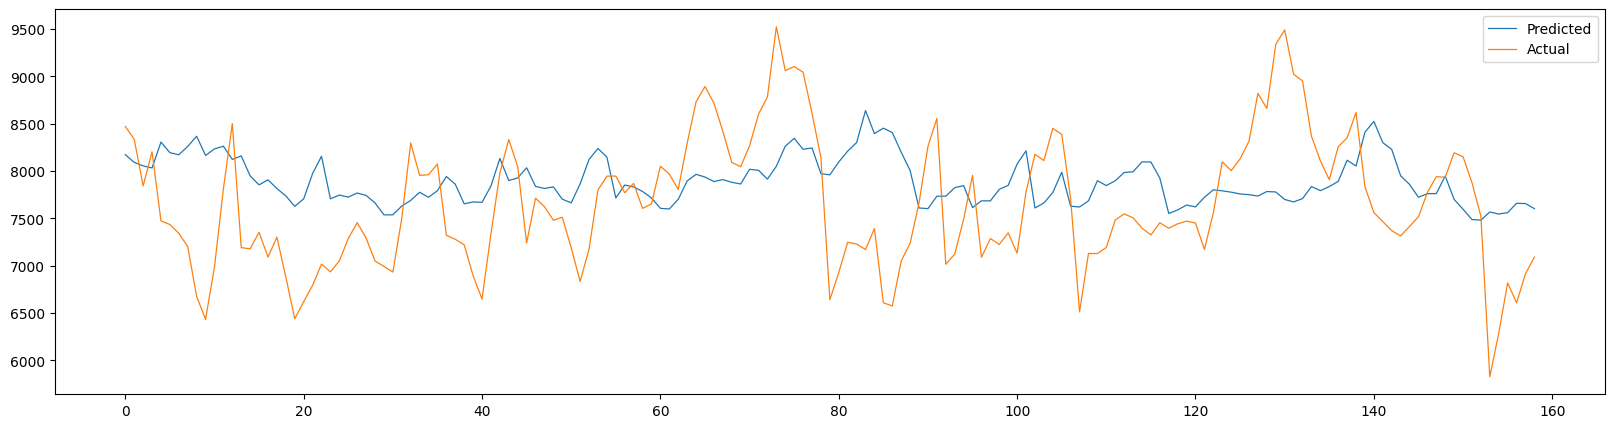

In [ ]:
d.plot(figsize=(20, 5), linewidth=0.9);

In [ ]:
##here index values which was first set as datetime are replaced with number but we can easily replace it back with dates .I'll set it at the end for test data

In [ ]:
model_0_eval = evaluate_preds(d['Actual'], d['Predicted'])
model_0_eval

{'mae': 622.7166,
 'mse': 559728.4,
 'rmse': 748.14996,
 'mape': 8.35404,
 'mase': 1.9775138}

###model 1 : same model with altering window value

In [ ]:
# model 1: by altering window value ,for inital model we have set to window = 10 and now
WINDOW_SIZE = 4
HORIZON = 1

In [ ]:
sequence, labels = window_maker(scaled_df, WINDOW_SIZE)
X_train, X_val, y_train, y_val = split_data(sequence, labels)
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((901, 4, 3), (160, 4, 3), (901,), (160,))

In [ ]:
# model 1
model_1 = tf.keras.Sequential([
    layers.Dense(128, activation = 'relu'),
    layers.Dense(128, activation="relu"),
    layers.Dense(HORIZON, activation = 'linear')
], name = 'model_1')

model_1.compile(loss = "mae",
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ['mae'])

In [ ]:
history_1 = model_1.fit(X_train,
                        y_train,
                        epochs = 100,
                        verbose = 0,
                        validation_data = (X_val, y_val),
                        callbacks = [create_model_checkpoint(model_name=model_1.name)])

In [ ]:
def plot_hist_curve(m_history):
  train_loss = m_history.history['loss']
  val_loss = m_history.history['val_loss']

  # Plot training and validation loss with lines
  epochs = range(1, len(train_loss) + 1)
  plt.plot(epochs, train_loss, 'b-', label='Training loss')
  plt.plot(epochs, val_loss, 'r-', label='Validation loss')
  plt.title('Training and Validation Loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()

  plt.show()

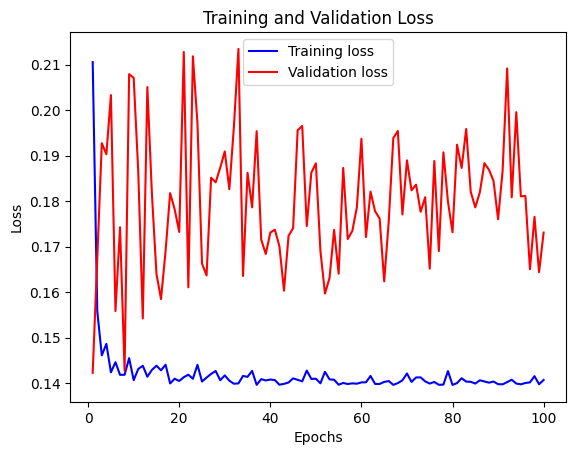

In [ ]:
plot_hist_curve(history_1)

In [ ]:
# loading best performing model
model_1 = tf.keras.models.load_model("/content/model_collection/model_1")
model_1.evaluate(X_val, y_val)

5/5 [==============================] - 0s 6ms/step - loss: 0.1423 - mae: 0.1423


[0.14226320385932922, 0.14226320385932922]

In [ ]:
pred = model_1.predict(X_val)
pred.shape

5/5 [==============================] - 0s 3ms/step


(160, 4, 1)

In [ ]:
d = {
    'Predicted': tf.squeeze(pred)[:, 0],
    'Actual': y_val[:]
}

d = pd.DataFrame(d)
d.head()

,Predicted,Actual
0,0.546442,0.557864
1,0.547818,0.603515
2,0.563963,0.572929
3,0.587848,0.460169
4,0.543181,0.542342


In [ ]:
d[['Predicted']] = output_scalar.inverse_transform(d[['Predicted']])
d[['Actual']] = output_scalar.inverse_transform(d[['Actual']])


d.head()

,Predicted,Actual
0,8219.960938,8270.0
1,8225.991211,8470.0
2,8296.723633,8336.0
3,8401.364258,7842.0
4,8205.673828,8202.0


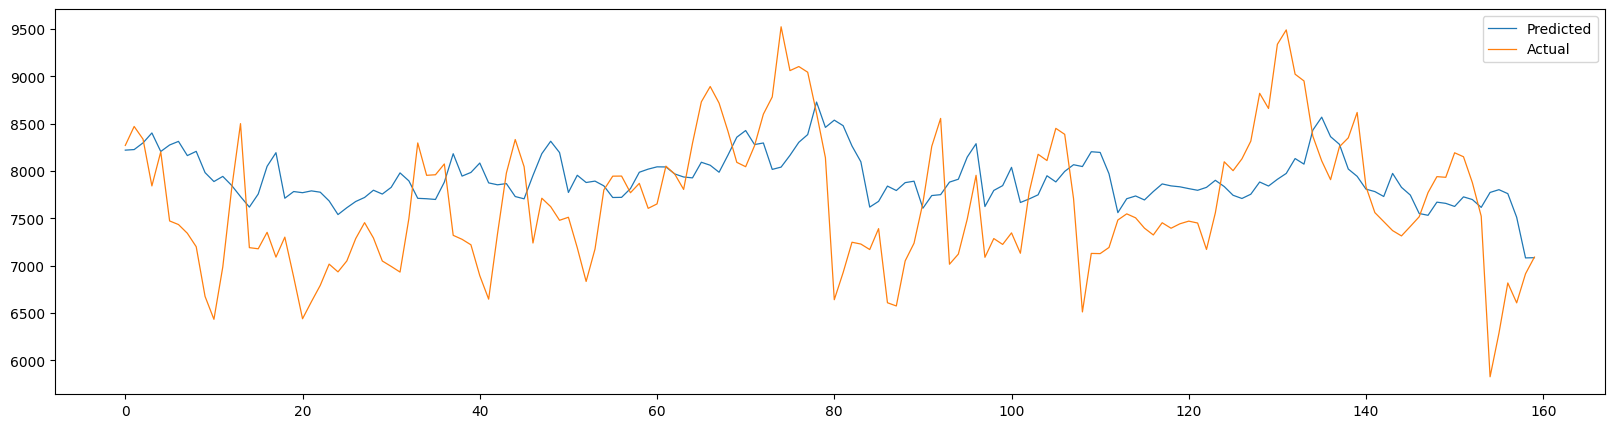

In [ ]:
d.plot(figsize=(20, 5), linewidth=0.9);

In [ ]:
model_1_eval = evaluate_preds(d['Actual'], d['Predicted'])
model_1_eval

{'mae': 580.76624,
 'mse': 503154.2,
 'rmse': 709.3336,
 'mape': 7.8345566,
 'mase': 1.8485373}

###model 2 : CNN with window 10 and horizon 1

In [ ]:
# model 2 : CNN window size 10 and horizon 1
WINDOW_SIZE = 10
HORIZON = 1

In [ ]:
sequence, labels = window_maker(scaled_df, WINDOW_SIZE)
X_train, X_val, y_train, y_val = split_data(sequence, labels)
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((896, 10, 3), (159, 10, 3), (896,), (159,))

In [ ]:
X_train.shape, y_train.shape

((896, 10, 3), (896,))

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Dense, Flatten, Dropout

In [ ]:
model_2 = Sequential()
model_2.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(10, 3)))
# model_3.add(Conv1D(filters=64, kernel_size=2, activation='relu'))

model_2.add(Flatten())
model_2.add(Dense(50, activation='relu'))


model_2.add(Dropout(0.5))

model_2.add(Dense(1))

# Compile the model
model_2.compile(optimizer='adam', loss='mse')


model_2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 9, 64)             448       
                                                                 
 flatten (Flatten)           (None, 576)               0         
                                                                 
 dense_6 (Dense)             (None, 50)                28850     
                                                                 
 dropout (Dropout)           (None, 50)                0         
                                                                 
 dense_7 (Dense)             (None, 1)                 51        
                                                                 
Total params: 29349 (114.64 KB)
Trainable params: 29349 (114.64 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
history_2 = model_2.fit(X_train, y_train,
                        epochs=100, batch_size=32,
                        validation_split=0.2,
                        verbose = 0,
                        callbacks=[create_model_checkpoint(model_name="model_2")])

In [ ]:
# loading best performing model
model_2 = tf.keras.models.load_model("/content/model_collection/model_2")
model_2.evaluate(X_val, y_val)

5/5 [==============================] - 0s 3ms/step - loss: 0.0107


0.010745272040367126

In [ ]:
pred = model_2.predict(X_val)
# pred = tf.squeeze(pred)
pred.shape

5/5 [==============================] - 0s 3ms/step


(159, 1)

In [ ]:
y_val.shape

(159,)

In [ ]:
d = {
    'Predicted': pred[:, 0],
    'Actual': y_val[:]
}

d = pd.DataFrame(d)
d.head()

,Predicted,Actual
0,0.572827,0.603515
1,0.598969,0.572929
2,0.538448,0.460169
3,0.487681,0.542342
4,0.547068,0.375713


In [ ]:
d[['Predicted']] = output_scalar.inverse_transform(d[['Predicted']])
d[['Actual']] = output_scalar.inverse_transform(d[['Actual']])


d.head()

,Predicted,Actual
0,8335.557617,8470.0
1,8450.084961,8336.0
2,8184.939941,7842.0
3,7962.530762,8202.0
4,8222.704102,7472.0


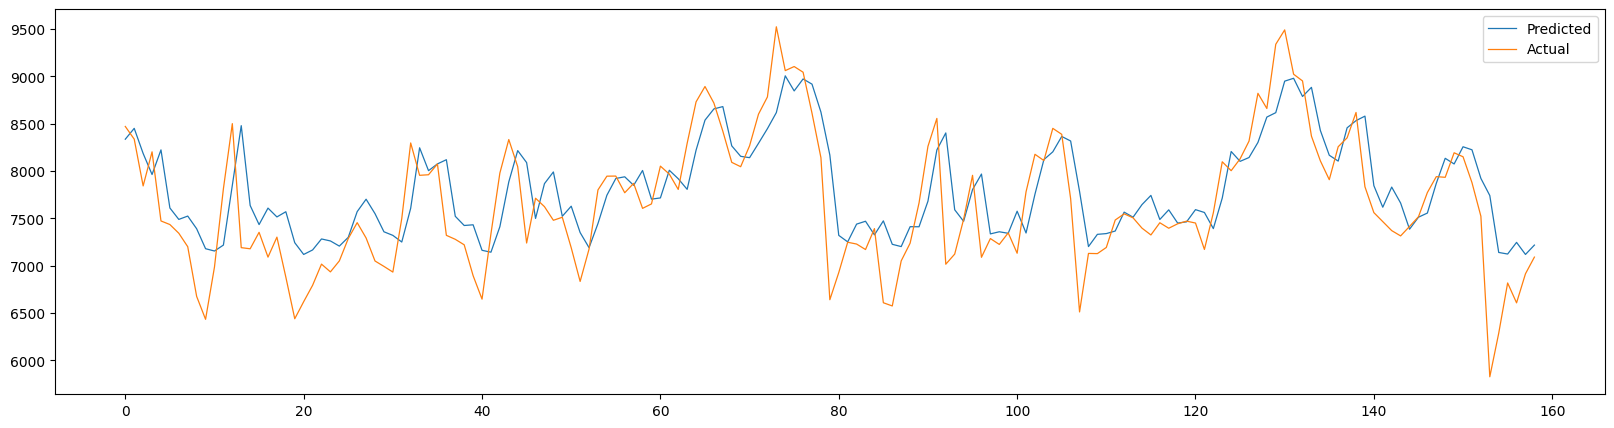

In [ ]:
d.plot(figsize=(20, 5), linewidth=0.9);

In [ ]:
model_2_eval = evaluate_preds(d['Actual'], d['Predicted'])
model_2_eval

{'mae': 332.6718,
 'mse': 206235.78,
 'rmse': 454.1319,
 'mape': 4.5130534,
 'mase': 1.0564406}

###model 3: CNN with window 10 and horizon 1

In [ ]:
# model 3: CNN with Window 10 and horizon 1
WINDOW_SIZE = 5
HORIZON = 1

In [ ]:
sequence, labels = window_maker(scaled_df, WINDOW_SIZE)
X_train, X_val, y_train, y_val = split_data(sequence, labels)
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((901, 5, 3), (159, 5, 3), (901,), (159,))

In [ ]:
model_3 = Sequential()
model_3.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(5, 3)))
# model_3.add(Conv1D(filters=64, kernel_size=2, activation='relu'))

model_3.add(Flatten())
model_3.add(Dense(50, activation='relu'))


model_3.add(Dropout(0.5))

model_3.add(Dense(1))

# Compile the model
model_3.compile(optimizer='adam', loss='mse')


model_3.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_1 (Conv1D)           (None, 4, 64)             448       
                                                                 
 flatten_1 (Flatten)         (None, 256)               0         
                                                                 
 dense_8 (Dense)             (None, 50)                12850     
                                                                 
 dropout_1 (Dropout)         (None, 50)                0         
                                                                 
 dense_9 (Dense)             (None, 1)                 51        
                                                                 
Total params: 13349 (52.14 KB)
Trainable params: 13349 (52.14 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
history_3 = model_3.fit(X_train, y_train,
                        epochs=100, batch_size=32,
                        validation_split=0.2,
                        verbose = 0,
                        callbacks=[create_model_checkpoint(model_name="model_3")])

In [ ]:
# loading best performing model
model_3 = tf.keras.models.load_model("/content/model_collection/model_3")
model_3.evaluate(X_val, y_val)

5/5 [==============================] - 1s 3ms/step - loss: 0.0099


0.00987209752202034

In [ ]:
pred = model_3.predict(X_val)
# pred = tf.squeeze(pred)
pred.shape

5/5 [==============================] - 0s 3ms/step


(159, 1)

In [ ]:
d = {
    'Predicted': pred[:, 0],
    'Actual': y_val[:]
}

d = pd.DataFrame(d)
d.head()

,Predicted,Actual
0,0.566721,0.603515
1,0.580486,0.572929
2,0.560037,0.460169
3,0.478092,0.542342
4,0.518882,0.375713


In [ ]:
d[['Predicted']] = output_scalar.inverse_transform(d[['Predicted']])
d[['Actual']] = output_scalar.inverse_transform(d[['Actual']])


d.head()

,Predicted,Actual
0,8308.802734,8470.0
1,8369.110352,8336.0
2,8279.520508,7842.0
3,7920.521973,8202.0
4,8099.222656,7472.0


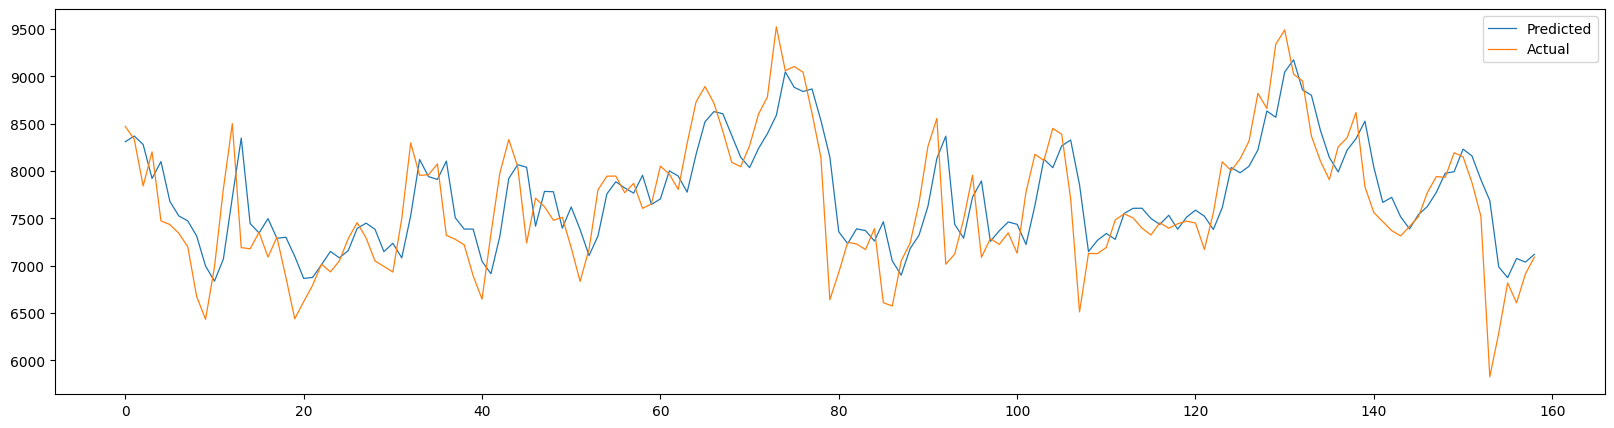

In [ ]:
d.plot(figsize=(20, 5), linewidth=0.9);

In [ ]:
model_3_eval = evaluate_preds(d['Actual'], d['Predicted'])
model_3_eval

{'mae': 315.04395,
 'mse': 189476.73,
 'rmse': 435.28925,
 'mape': 4.226441,
 'mase': 1.0004611}

###model 4: RNN-LSTM model with window 10 and horizon 1

In [ ]:
# model 4 : RNN-LSTM  with window 10 and horizon 1
WINDOW_SIZE = 10
HORIZON = 1

In [ ]:
sequence, labels = window_maker(scaled_df, WINDOW_SIZE)
X_train, X_val, y_train, y_val = split_data(sequence, labels)
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((896, 10, 3), (159, 10, 3), (896,), (159,))

In [ ]:
inputs = layers.Input(shape=(10, 3))

x = layers.LSTM(128, activation="relu", return_sequences=True)(inputs)
x = layers.LSTM(128, activation="relu")(x)
x = layers.Dense(32, activation="relu")(x)
output = layers.Dense(1)(x)
model_4 = tf.keras.Model(inputs=inputs, outputs=output, name="model_4")



# Compile model
model_4.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())
model_4.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 10, 3)]           0         
                                                                 
 lstm (LSTM)                 (None, 10, 128)           67584     
                                                                 
 lstm_1 (LSTM)               (None, 128)               131584    
                                                                 
 dense_10 (Dense)            (None, 32)                4128      
                                                                 
 dense_11 (Dense)            (None, 1)                 33        
                                                                 
Total params: 203329 (794.25 KB)
Trainable params: 203329 (794.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
history_4 = model_4.fit(X_train,
            y_train,
            epochs=100,
            verbose=0,
            batch_size=32,
            validation_split=0.2,
            callbacks=[create_model_checkpoint(model_name=model_4.name)])

In [ ]:
# loading best performing model
model_4 = tf.keras.models.load_model("/content/model_collection/model_4")
model_4.evaluate(X_val, y_val)

5/5 [==============================] - 0s 11ms/step - loss: 0.0724


0.07243791222572327

In [ ]:
pred = model_4.predict(X_val)
# pred = tf.squeeze(pred)
pred.shape

5/5 [==============================] - 0s 11ms/step


(159, 1)

In [ ]:
d = {
    'Predicted': pred[:, 0],
    'Actual': y_val[:]
}

d = pd.DataFrame(d)
d.head()

,Predicted,Actual
0,0.570114,0.603515
1,0.601441,0.572929
2,0.561001,0.460169
3,0.479073,0.542342
4,0.543474,0.375713


In [ ]:
d[['Predicted']] = output_scalar.inverse_transform(d[['Predicted']])
d[['Actual']] = output_scalar.inverse_transform(d[['Actual']])


d.head()

,Predicted,Actual
0,8323.669922,8470.0
1,8460.914062,8336.0
2,8283.745117,7842.0
3,7924.820801,8202.0
4,8206.958008,7472.0


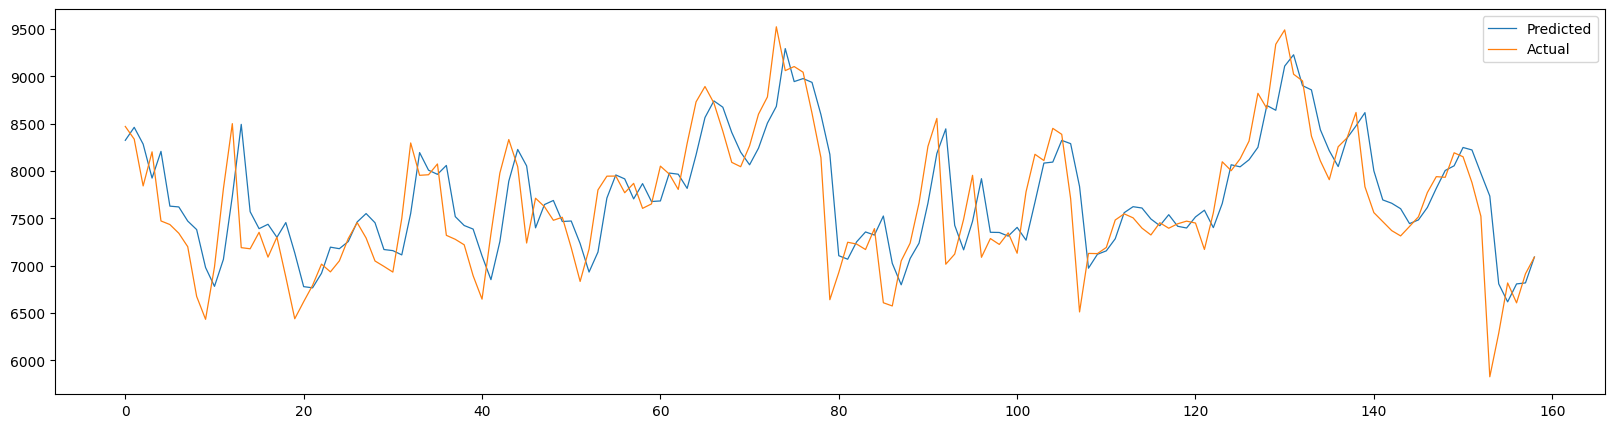

In [ ]:
d.plot(figsize=(20, 5), linewidth=0.9);

In [ ]:
model_4_eval = evaluate_preds(d['Actual'], d['Predicted'])
model_4_eval

{'mae': 317.35046,
 'mse': 194889.77,
 'rmse': 441.4632,
 'mape': 4.2618747,
 'mase': 1.0077858}

###model 5 : RNN LSTM with window 15 and horizon = 1

In [ ]:
# model 5: RNN LSTM with WINDOW = 3 horizon = 1
WINDOW_SIZE = 15
HORIZON = 1

In [ ]:
sequence, labels = window_maker(scaled_df, WINDOW_SIZE)
X_train, X_val, y_train, y_val = split_data(sequence, labels)
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((892, 15, 3), (158, 15, 3), (892,), (158,))

In [ ]:
inputs = layers.Input(shape=(15, 3))

x = layers.LSTM(128, activation="relu", return_sequences=True)(inputs)
x = layers.LSTM(128, activation="relu")(x)
x = layers.Dense(32, activation="relu")(x)
output = layers.Dense(1)(x)
model_5 = tf.keras.Model(inputs=inputs, outputs=output, name="model_5")



# Compile model
model_5.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())
model_5.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 15, 3)]           0         
                                                                 
 lstm_2 (LSTM)               (None, 15, 128)           67584     
                                                                 
 lstm_3 (LSTM)               (None, 128)               131584    
                                                                 
 dense_12 (Dense)            (None, 32)                4128      
                                                                 
 dense_13 (Dense)            (None, 1)                 33        
                                                                 
Total params: 203329 (794.25 KB)
Trainable params: 203329 (794.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
history_5 = model_5.fit(X_train,
            y_train,
            epochs=100,
            verbose=0,
            batch_size=32,
            validation_split=0.2,
            callbacks=[create_model_checkpoint(model_name=model_5.name)])

In [ ]:
# loading best performing model
model_5 = tf.keras.models.load_model("/content/model_collection/model_5")
model_5.evaluate(X_val, y_val)

5/5 [==============================] - 0s 16ms/step - loss: 0.0713


0.07129490375518799

In [ ]:
pred = model_5.predict(X_val)
# pred = tf.squeeze(pred)
pred.shape

5/5 [==============================] - 0s 15ms/step


(158, 1)

In [ ]:
d = {
    'Predicted': pred[:, 0],
    'Actual': y_val[:]
}

d = pd.DataFrame(d)
d.head()

,Predicted,Actual
0,0.627880,0.572929
1,0.557631,0.460169
2,0.469398,0.542342
3,0.576900,0.375713
4,0.374726,0.367039


In [ ]:
d[['Predicted']] = output_scalar.inverse_transform(d[['Predicted']])
d[['Actual']] = output_scalar.inverse_transform(d[['Actual']])


d.head()

,Predicted,Actual
0,8576.742188,8336.0
1,8268.979492,7842.0
2,7882.431641,8202.0
3,8353.399414,7472.0
4,7467.675293,7434.0


<Axes: >

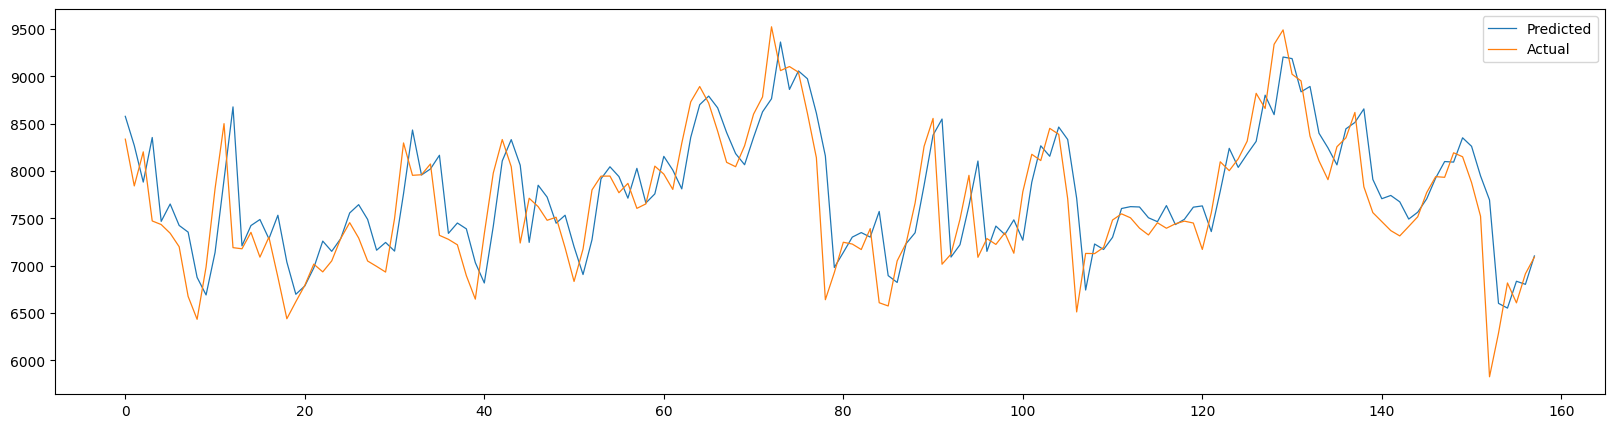

In [ ]:
d.plot(figsize=(20, 5), linewidth=0.9)

In [ ]:
model_5_eval = evaluate_preds(d['Actual'], d['Predicted'])
model_5_eval

{'mae': 312.343,
 'mse': 191348.73,
 'rmse': 437.43427,
 'mape': 4.2030754,
 'mase': 0.9882678}

####see till now results of different models

In [ ]:
results = [
    {'model': 'model_0', **model_0_eval},
    {'model': 'model_1', **model_1_eval},
    {'model': 'model_2', **model_2_eval},
    {'model': 'model_3', **model_3_eval},
    {'model': 'model_4', **model_4_eval},
    {'model': 'model_5', **model_5_eval}
]
result_df = pd.DataFrame(results)

In [ ]:
result_df

,model,mae,mse,rmse,mape,mase
0,model_0,622.716614,559728.375000,748.149963,8.354040,1.977514
1,model_1,580.766235,503154.187500,709.333618,7.834557,1.848537
2,model_2,332.671814,206235.781250,454.131897,4.513053,1.056441
3,model_3,315.043945,189476.734375,435.289246,4.226441,1.000461
4,model_4,317.350464,194889.765625,441.463196,4.261875,1.007786
5,model_5,312.342987,191348.734375,437.434265,4.203075,0.988268


#Testing Above model 5 with test dataset (unseen)

In [ ]:
# test model 5 with test data
test_df.head()

,energydemand,min temparature,max temparature
Date,,,
2020-12-02,7123,19.73,29.54
2020-12-03,7124,20.81,29.65
2020-12-04,7218,21.38,28.54
2020-12-05,7115,21.39,30.07
2020-12-06,6819,20.99,30.16


In [ ]:
# for model 5 we need to set window size to 15 and horizon to 1
# so we need 15 previous observations to forecast next 30

In [ ]:
test_df.shape

(30, 3)

In [ ]:
prev_observ = train_df.tail(15)

new_test_df = pd.concat(objs=[prev_observ, test_df])
new_test_df.shape


(45, 3)

In [ ]:
new_test_df.head()

,energydemand,min temparature,max temparature
Date,,,
2020-11-17,7414,22.93,29.49
2020-11-18,7516,22.84,31.15
2020-11-19,7772,23.01,31.73
2020-11-20,7940,22.09,32.20
2020-11-21,7933,20.89,31.80


Text(0, 0.5, 'Energy Consumption')

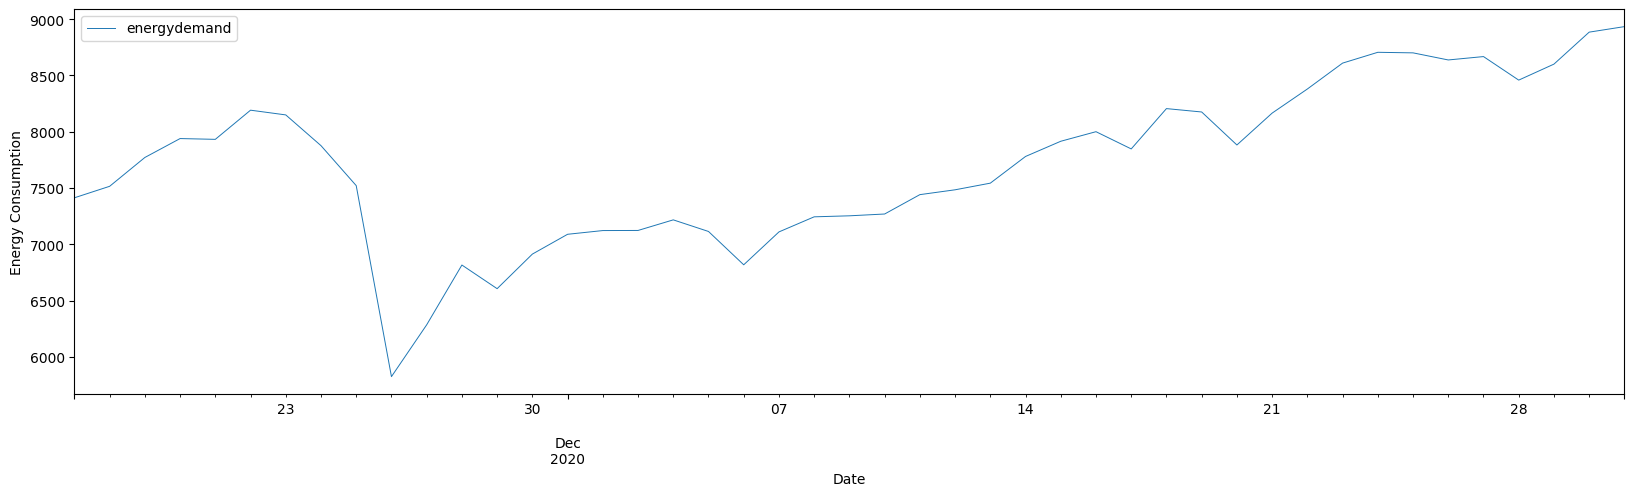

In [ ]:
pd.DataFrame(new_test_df["energydemand"]).plot(figsize=(20, 5),linewidth=0.7)
plt.ylabel("Energy Consumption")

In [ ]:
new_test_df = new_test_df.sort_index()

In [ ]:
test_scaled_df = scalar.fit_transform(new_test_df.to_numpy())
test_scaled_df = pd.DataFrame(test_scaled_df, columns = list(test_df.columns))

In [ ]:
test_scaled_df[["energydemand"]] = output_scalar.fit_transform(new_test_df[['energydemand']].to_numpy())

In [ ]:
test_scaled_df.index = new_test_df.index

In [ ]:
sequence, labels = window_maker(test_scaled_df, 15)


In [ ]:
sequence.shape, labels.shape

((30, 15, 3), (30,))

In [ ]:
test_pred = model_5.predict(sequence)

1/1 [==============================] - 0s 55ms/step


In [ ]:
test_pred.shape

(30, 1)

In [ ]:
d = {
    'Predicted': test_pred[:, 0],
    'Actual': labels[:]
}

test_d = pd.DataFrame(d)
test_d.head()

,Predicted,Actual
0,0.503924,0.417310
1,0.485290,0.417632
2,0.479682,0.447876
3,0.471612,0.414736
4,0.482062,0.319498


In [ ]:
test_d.index = test_df.index

In [ ]:
test_d[['Predicted']] = output_scalar.inverse_transform(test_d[['Predicted']])
test_d[['Actual']] = output_scalar.inverse_transform(test_d[['Actual']])


test_d.head()

,Predicted,Actual
Date,,
2020-12-02,7392.195801,7123.0
2020-12-03,7334.281738,7124.0
2020-12-04,7316.851074,7218.0
2020-12-05,7291.770020,7115.0
2020-12-06,7324.248535,6819.0


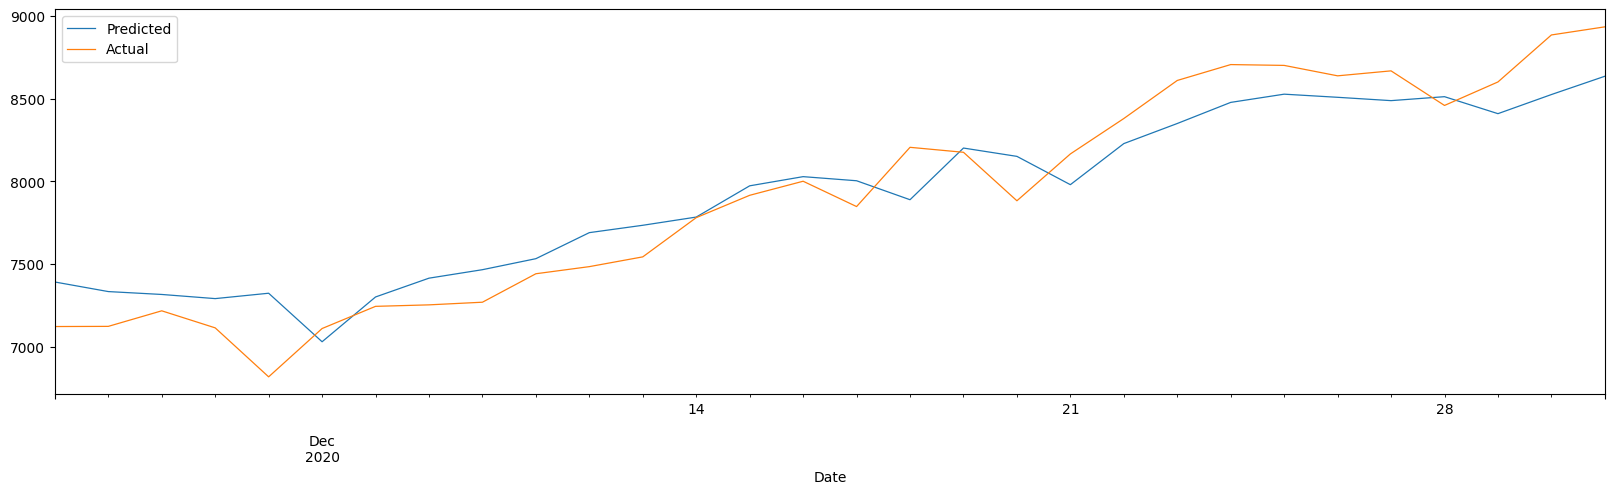

In [ ]:
test_d.plot(figsize=(20, 5), linewidth=0.9);

###In above Graph, Blue line Shows Enenrgy demand for next 30 days based on temperature trend

In [ ]:
test_whole_df = pd.merge(test_d, test_df[["min temparature", "max temparature"]], left_index=True, right_index=True, how='outer')

In [ ]:
test_whole_df.tail()

,Predicted,Actual,min temparature,max temparature
Date,,,,
2020-12-27,8488.100586,8668.0,18.08,29.03
2020-12-28,8511.973633,8459.0,18.12,29.21
2020-12-29,8409.375977,8601.0,18.38,29.71
2020-12-30,8524.885742,8885.0,19.68,29.42
2020-12-31,8635.424805,8934.0,20.82,29.28


In [ ]:
df.tail()

,energydemand,min temparature,max temparature
Date,,,
2020-12-27,8668,18.08,29.03
2020-12-28,8459,18.12,29.21
2020-12-29,8601,18.38,29.71
2020-12-30,8885,19.68,29.42
2020-12-31,8934,20.82,29.28


In [ ]:
test_eval_res = evaluate_preds(test_d['Actual'], test_d['Predicted'])
test_eval_res

{'mae': 176.99712,
 'mse': 43019.24,
 'rmse': 207.4108,
 'mape': 2.2519317,
 'mase': 1.2473674}

### here we got the mean absolute error as 176 for test set which can be still improvable by hypertuning the neural layers

###Out of all models LSTM model with model name model_5 performed  well which is Recurrent Neural Network. As expected RNN works well with sequential data

 also the dataset is little bit short in volume to generate better result from larger datasets we can do batch normalization to improve preformance by tackling overfitting of the model

___

##model_6 : hypertuning previous lstm

In [ ]:
WINDOW_SIZE = 6
HORIZON = 1

In [ ]:
sequence, labels = window_maker(scaled_df, WINDOW_SIZE)
X_train, X_val, y_train, y_val = split_data(sequence, labels)
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((900, 6, 3), (159, 6, 3), (900,), (159,))

In [ ]:
model_6 = Sequential()
model_6.add(layers.LSTM(200, input_shape=(X_train.shape[1], X_train.shape[2])))
# model_6.add(layers.Dropout(0.2))
# model_6.add(layers.LSTM(100))
model_6.add(layers.Dense(128, activation='relu'))
model_6.add(layers.Dropout(0.2))
model_6.add(layers.Dense(64, activation='relu'))
model_6.add(layers.Dropout(0.3))
model_6.add(layers.Dense(1, activation='linear'))

model_6.compile(loss = 'MeanSquaredError',
                metrics=['MAE'],
                optimizer=tf.keras.optimizers.Adam())
model_6.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 200)               163200    
                                                                 
 dense_14 (Dense)            (None, 128)               25728     
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_15 (Dense)            (None, 64)                8256      
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                                                                 
 dense_16 (Dense)            (None, 1)                 65        
                                                                 
Total params: 197249 (770.50 KB)
Trainable params: 197

In [ ]:
history_6 = model_6.fit(X_train,
            y_train,
            batch_size=32,
            epochs=50,
            verbose=1,
            validation_split=0.2,
            callbacks=[create_model_checkpoint(model_name="model_6"),
                      #  tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=7, restore_best_weights=True),
                       LearningRateScheduler(scheduler)])

Epoch 1/50
23/23 [==============================] - 9s 295ms/step - loss: 0.0736 - MAE: 0.2101 - val_loss: 0.0338 - val_MAE: 0.1484 - lr: 0.0010
Epoch 2/50
23/23 [==============================] - 4s 190ms/step - loss: 0.0234 - MAE: 0.1226 - val_loss: 0.0300 - val_MAE: 0.1477 - lr: 0.0010
Epoch 3/50
23/23 [==============================] - 5s 237ms/step - loss: 0.0177 - MAE: 0.1058 - val_loss: 0.0161 - val_MAE: 0.1016 - lr: 0.0010
Epoch 4/50
23/23 [==============================] - 4s 200ms/step - loss: 0.0161 - MAE: 0.0998 - val_loss: 0.0143 - val_MAE: 0.0903 - lr: 0.0010
Epoch 5/50
23/23 [==============================] - 0s 17ms/step - loss: 0.0154 - MAE: 0.0971 - val_loss: 0.0201 - val_MAE: 0.1188 - lr: 0.0010
Epoch 6/50
23/23 [==============================] - 5s 239ms/step - loss: 0.0162 - MAE: 0.0992 - val_loss: 0.0141 - val_MAE: 0.0931 - lr: 0.0010
Epoch 7/50
23/23 [==============================] - 5s 236ms/step - loss: 0.0152 - MAE: 0.0959 - val_loss: 0.0133 - val_MAE: 0.0866

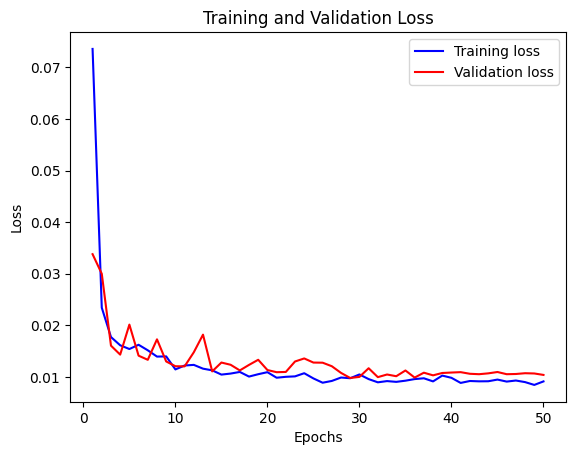

In [ ]:
plot_hist_curve(history_6)

In [ ]:
# inputs = layers.Input(shape=(15, 3))

# x = layers.LSTM(128, activation="relu", return_sequences=True)(inputs)
# x = layers.LSTM(128, activation="relu")(x)
# x = layers.Dense(32, activation="relu")(x)
# output = layers.Dense(1)(x)
# model_5 = tf.keras.Model(inputs=inputs, outputs=output, name="model_5")



# # Compile model
# model_5.compile(loss="mae",
#                 optimizer=tf.keras.optimizers.Adam())
# model_5.summary()

In [ ]:
# loading best performing model
model_6 = tf.keras.models.load_model("/content/model_collection/model_6")
model_6.evaluate(X_val, y_val)

5/5 [==============================] - 1s 7ms/step - loss: 0.0121 - MAE: 0.0802


[0.012133367359638214, 0.08023584634065628]

In [ ]:
pred = model_6.predict(X_val)
# pred = tf.squeeze(pred)
pred.shape

5/5 [==============================] - 0s 7ms/step


(159, 1)

In [ ]:
d = {
    'Predicted': pred[:, 0],
    'Actual': y_val[:]
}

d = pd.DataFrame(d)
d.head()

,Predicted,Actual
0,0.626144,0.603515
1,0.619292,0.572929
2,0.592952,0.460169
3,0.524374,0.542342
4,0.541631,0.375713


In [ ]:
d[['Predicted']] = output_scalar.inverse_transform(d[['Predicted']])
d[['Actual']] = output_scalar.inverse_transform(d[['Actual']])


d.head()

,Predicted,Actual
0,7772.057129,7701.725177
1,7750.761230,7606.661949
2,7668.893555,7256.204976
3,7455.753906,7511.598722
4,7509.387695,6993.716960


<Axes: >

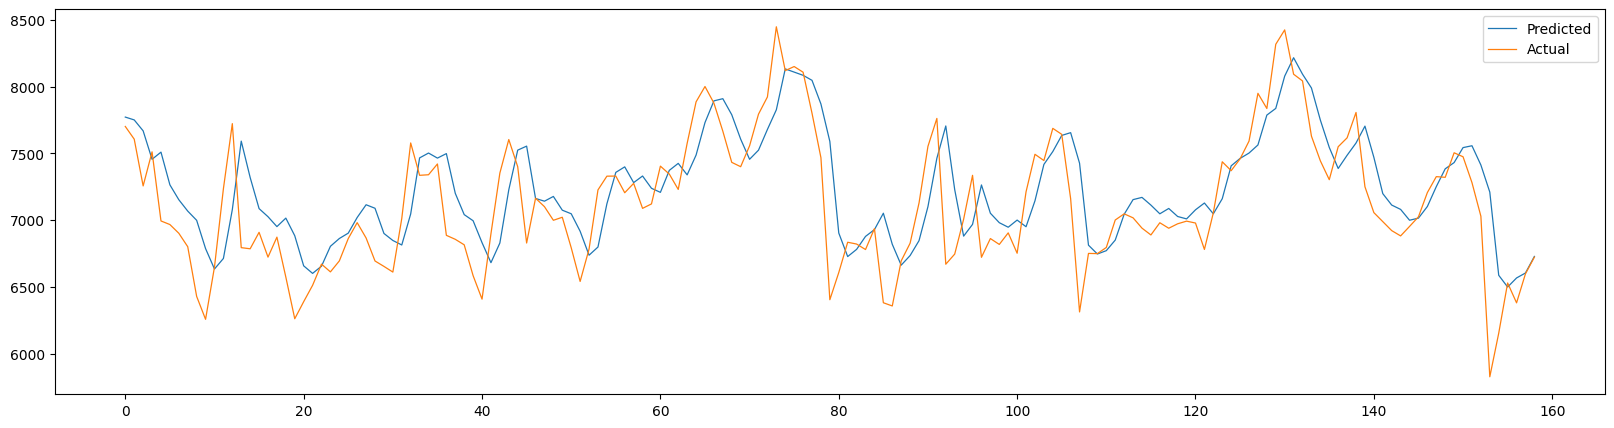

In [ ]:
d.plot(figsize=(20, 5), linewidth=0.9)

In [ ]:
model_6_eval = evaluate_preds(d['Actual'], d['Predicted'])
model_6_eval

{'mae': 249.37299,
 'mse': 117204.25,
 'rmse': 342.35107,
 'mape': 3.5807974,
 'mase': 1.1162739}

In [ ]:
model_5_eval

{'mae': 312.343,
 'mse': 191348.73,
 'rmse': 437.43427,
 'mape': 4.2030754,
 'mase': 0.9882678}

###**by comparing results of model_5 and hpyertuned model_6 we can see that model_6 has improvement in reducing mean absolute error by almost 50**

###just by altering some layers and introducing learningschedular callback function we improved our lstm model performance

___

# the another approach to this problem is by setting horizon value more than 1

###model 7

In [ ]:
WINDOW_SIZE  = 30
HORIZON = 5

# here we take window of 30 to forecast next 5 horizon values

In [ ]:

scaled_df = scalar.fit_transform(train_df.to_numpy())
scaled_df = pd.DataFrame(scaled_df, columns = list(train_df.columns))

In [ ]:
scaled_df[["energydemand"]] = output_scalar.fit_transform(train_df[['energydemand']].to_numpy())

In [ ]:
def window_maker(df, window, horizon):
    sequences = []
    labels = []

    for i in range(len(df) - window - horizon + 1):
        # Extract the window and label
        window_data = df.iloc[i:i+window].values.tolist()
        label_data = df['energydemand'].iloc[i+window:i+window+horizon].values.tolist()

        sequences.append(window_data)
        labels.append(label_data)

    return np.array(sequences), np.array(labels)

In [ ]:
seq, labels = window_maker(scaled_df, WINDOW_SIZE, HORIZON)

In [ ]:
seq.shape, labels.shape

((1031, 30, 3), (1031, 5))

In [ ]:
seq[2], labels[2]

(array([[0.55968957, 0.3143049 , 0.35567568],
        [0.55055923, 0.26192075, 0.35837838],
        [0.54918968, 0.15446608, 0.31189189],
        [0.55329833, 0.14439221, 0.31945946],
        [0.52818991, 0.16319678, 0.31567568],
        [0.56197215, 0.23774345, 0.28648649],
        [0.55717873, 0.27266622, 0.27189189],
        [0.59392833, 0.33646743, 0.3372973 ],
        [0.59004793, 0.39691068, 0.38      ],
        [0.62360192, 0.39086635, 0.42486486],
        [0.57361333, 0.39825386, 0.41297297],
        [0.52545081, 0.32907992, 0.39891892],
        [0.46884273, 0.35594359, 0.39027027],
        [0.58799361, 0.31027535, 0.38594595],
        [0.52978772, 0.22095366, 0.3627027 ],
        [0.58388496, 0.20013432, 0.35567568],
        [0.5496462 , 0.19677636, 0.33135135],
        [0.52271171, 0.16319678, 0.33135135],
        [0.5578635 , 0.14304903, 0.32702703],
        [0.59643917, 0.2014775 , 0.30810811],
        [0.62246063, 0.25319006, 0.33135135],
        [0.62063456, 0.28139691, 0

In [ ]:
X_train, X_val, y_train, y_val = split_data(seq, labels)
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((876, 30, 3), (155, 30, 3), (876, 5), (155, 5))

In [ ]:
inputs = layers.Input(shape=(30, 3))
x = layers.LSTM(200, activation="relu", return_sequences=True)(inputs)
x = layers.Dropout(0.2)(x)
x = layers.LSTM(128, activation="relu")(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(32, activation="relu")(x)
x = layers.Dropout(0.2)(x)
output = layers.Dense(5, activation='linear')(x)
model_7 = tf.keras.Model(inputs=inputs, outputs=output, name="model_7")

model_7.compile(loss="MeanSquaredError",
                optimizer=tf.keras.optimizers.Adam(),
                metrics = ['mae'])


model_7.summary()

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 30, 3)]           0         
                                                                 
 lstm_9 (LSTM)               (None, 30, 200)           163200    
                                                                 
 dropout_10 (Dropout)        (None, 30, 200)           0         
                                                                 
 lstm_10 (LSTM)              (None, 128)               168448    
                                                                 
 dropout_11 (Dropout)        (None, 128)               0         
                                                                 
 dense_21 (Dense)            (None, 32)                4128      
                                                                 
 dropout_12 (Dropout)        (None, 32)                0   

In [ ]:

history_7 = model_7.fit(X_train,
            y_train,
            batch_size=128,
            epochs=50,
            verbose=1,
            validation_split=0.2,
            callbacks=[create_model_checkpoint(model_name=model_7.name),
                       LearningRateScheduler(scheduler)])

Epoch 1/50
6/6 [==============================] - 10s 1s/step - loss: 0.2580 - mae: 0.4756 - val_loss: 0.2372 - val_mae: 0.4266 - lr: 0.0010
Epoch 2/50
6/6 [==============================] - 5s 908ms/step - loss: 0.1217 - mae: 0.2777 - val_loss: 0.1052 - val_mae: 0.2792 - lr: 0.0010
Epoch 3/50
6/6 [==============================] - 6s 1s/step - loss: 0.0829 - mae: 0.2287 - val_loss: 0.0917 - val_mae: 0.2630 - lr: 0.0010
Epoch 4/50
6/6 [==============================] - 5s 1s/step - loss: 0.0700 - mae: 0.2097 - val_loss: 0.0507 - val_mae: 0.1927 - lr: 0.0010
Epoch 5/50
6/6 [==============================] - 7s 1s/step - loss: 0.0595 - mae: 0.1917 - val_loss: 0.0401 - val_mae: 0.1704 - lr: 0.0010
Epoch 6/50
6/6 [==============================] - 2s 263ms/step - loss: 0.0592 - mae: 0.1902 - val_loss: 0.0473 - val_mae: 0.1861 - lr: 0.0010
Epoch 7/50
6/6 [==============================] - 5s 923ms/step - loss: 0.0537 - mae: 0.1809 - val_loss: 0.0361 - val_mae: 0.1608 - lr: 0.0010
Epoch 8/50

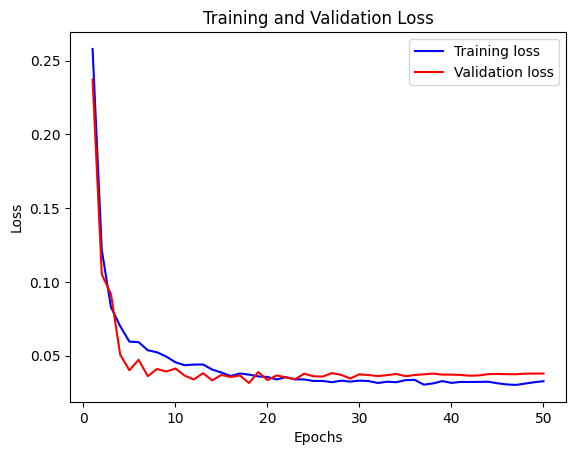

In [ ]:
plot_hist_curve(history_7)

In [ ]:
# model_6 = tf.keras.Sequential([
#     tf.keras.layers.Dense(128, activation="relu"),
#     tf.keras.layers.Dense(5)
# ], name="model_6")

# model_6.compile(loss="mae",
#                 optimizer=tf.keras.optimizers.Adam())

# X_train_reshaped = X_train.reshape(X_train.shape[0], -1)
# # Train the model
# model_6.fit(X_train_reshaped,
#             y_train,
#             batch_size=128,
#             epochs=100,
#             verbose=1,
#             validation_split=0.2,
#             callbacks=[create_model_checkpoint(model_name=model_6.name)])

In [ ]:
# loading best performing model
model_7 = tf.keras.models.load_model("/content/model_collection/model_7")
model_7.evaluate(X_val, y_val)

5/5 [==============================] - 1s 36ms/step - loss: 0.0264 - mae: 0.1296


[0.026448877528309822, 0.12962797284126282]

In [ ]:
pred = model_7.predict(X_val)
# pred = tf.squeeze(pred)
pred.shape

5/5 [==============================] - 1s 36ms/step


(155, 5)

In [ ]:
y_val.shape

(155, 5)

In [ ]:
y_val[:, 0]

array([0.60351518, 0.57292856, 0.46016891, 0.54234193, 0.37571331,
       0.36703949, 0.34603972, 0.31362703, 0.19379137, 0.13855284,
       0.26477973, 0.45332116, 0.61036293, 0.31134444, 0.30860534,
       0.3483223 , 0.2885186 , 0.33668112, 0.24035608, 0.13992239,
       0.1810089 , 0.2204976 , 0.27162748, 0.25291029, 0.27938827,
       0.33325725, 0.37160466, 0.3346268 , 0.27916001, 0.26614928,
       0.25245378, 0.38164803, 0.56379822, 0.48573385, 0.4871034 ,
       0.51312486, 0.34101803, 0.33143118, 0.31819219, 0.24377996,
       0.18717188, 0.34489843, 0.49121205, 0.57201552, 0.50650536,
       0.3225291 , 0.43049532, 0.41018032, 0.37731112, 0.38461538,
       0.31111618, 0.2298562 , 0.30792057, 0.45058206, 0.48367953,
       0.48390778, 0.44373431, 0.46633189, 0.40607167, 0.41679982,
       0.50787491, 0.48870121, 0.45172335, 0.56288519, 0.66286236,
       0.69984022, 0.659895  , 0.59210226, 0.51700525, 0.50650536,
       0.55695047, 0.63318877, 0.6747318 , 0.84387126, 0.73818

In [ ]:
d = {
    'Predicted': pred[:, 0],
    'Actual': y_val[:, 0]
}

d = pd.DataFrame(d)
d.head()

,Predicted,Actual
0,0.496828,0.603515
1,0.498163,0.572929
2,0.498692,0.460169
3,0.496797,0.542342
4,0.495380,0.375713


In [ ]:
d[['Predicted']] = output_scalar.inverse_transform(d[['Predicted']])
d[['Actual']] = output_scalar.inverse_transform(d[['Actual']])


d.head(15)

,Predicted,Actual
0,8002.604004,8470.0
1,8008.452637,8336.0
2,8010.769043,7842.0
3,8002.465332,8202.0
4,7996.261230,7472.0
5,7974.376465,7434.0
6,7943.679199,7342.0
7,7905.276855,7200.0
8,7860.426270,6675.0
9,7809.796875,6433.0


In [ ]:
d.head()

,Predicted,Actual
0,8002.604004,8470.0
1,8008.452637,8336.0
2,8010.769043,7842.0
3,8002.465332,8202.0
4,7996.261230,7472.0


<Axes: >

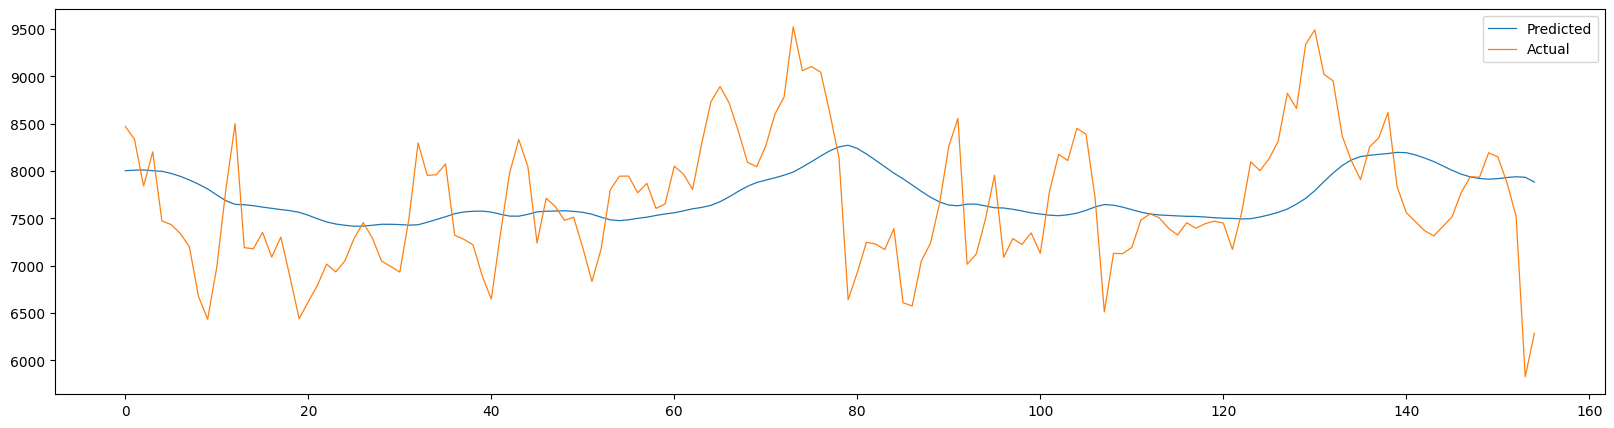

In [ ]:
d.plot(figsize=(20, 5), linewidth=0.9)

In [ ]:
model_7_eval = evaluate_preds(d['Actual'], d['Predicted'])
model_7_eval

{'mae': 534.67096,
 'mse': 451743.28,
 'rmse': 672.1185,
 'mape': 7.0482945,
 'mase': 1.6966685}

In [ ]:
# got too less accuracy than expected

By hypertuning this model also we can get better accuracy and also by experimenting more and more on models but for now



```
model_6_eval = {'mae': 249.37299,
 'mse': 117204.25,
 'rmse': 342.35107,
 'mape': 3.5807974,
 'mase': 1.1162739}
```

model 6 lstm model gave better accuracy by chasing model 5

#Final Test for next 30 Days Forecasting based on trend in temparature
by using model_6

In [ ]:
test_df.head()

,energydemand,min temparature,max temparature
Date,,,
2020-12-02,7123,19.73,29.54
2020-12-03,7124,20.81,29.65
2020-12-04,7218,21.38,28.54
2020-12-05,7115,21.39,30.07
2020-12-06,6819,20.99,30.16


In [ ]:
test_df.shape

(30, 3)

using temparature trend from these 30 days to predict Energy consumption

for model 6 we have took window size of 6 and horizon 1 so here for testing on unseen data of 30 days we need previous 6 days data from those 30days to forecast first day of next 30 and then continue

In [ ]:
prev_observ = train_df.tail(6)

new_test_df = pd.concat(objs=[prev_observ, test_df])
new_test_df.shape


(36, 3)

In [ ]:
new_test_df.head()

,energydemand,min temparature,max temparature
Date,,,
2020-11-26,5826,21.24,28.09
2020-11-27,6286,19.81,23.78
2020-11-28,6817,19.98,23.92
2020-11-29,6607,21.75,26.98
2020-11-30,6914,20.77,28.53


In [ ]:
new_test_df = new_test_df.sort_index()

In [ ]:
test_scaled_df = scalar.fit_transform(new_test_df.to_numpy())
test_scaled_df = pd.DataFrame(test_scaled_df, columns = list(test_df.columns))

In [ ]:
test_scaled_df[["energydemand"]] = output_scalar.fit_transform(new_test_df[['energydemand']].to_numpy())

In [ ]:
sequence, labels = window_maker(test_scaled_df, 6)

In [ ]:
sequence.shape, labels.shape

((30, 6, 3), (30,))

In [ ]:
test_pred = model_6.predict(sequence)

1/1 [==============================] - 0s 53ms/step


In [ ]:
d = {
    'Predicted': test_pred[:, 0],
    'Actual': labels[:]
}

test_d = pd.DataFrame(d)
test_d.head()

,Predicted,Actual
0,0.517560,0.417310
1,0.546348,0.417632
2,0.540485,0.447876
3,0.513270,0.414736
4,0.512398,0.319498


In [ ]:
test_d.index = test_df.index

In [ ]:
test_d[['Predicted']] = output_scalar.inverse_transform(test_d[['Predicted']])
test_d[['Actual']] = output_scalar.inverse_transform(test_d[['Actual']])


test_d.head()

,Predicted,Actual
Date,,
2020-12-02,7434.576660,7123.0
2020-12-03,7524.048828,7124.0
2020-12-04,7505.828613,7218.0
2020-12-05,7421.242188,7115.0
2020-12-06,7418.534180,6819.0


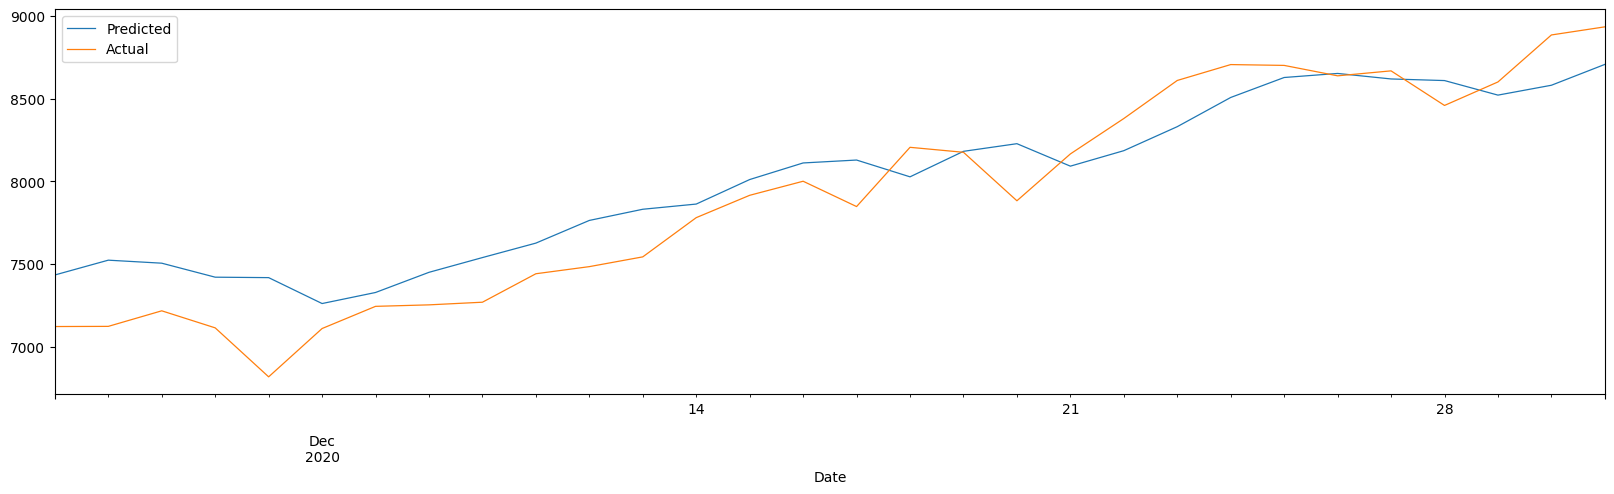

In [ ]:
test_d.plot(figsize=(20, 5), linewidth=0.9);

In [ ]:
test_eval_res2 = evaluate_preds(test_d['Actual'], test_d['Predicted'])
test_eval_res2

{'mae': 203.32341,
 'mse': 57624.96,
 'rmse': 240.052,
 'mape': 2.6543224,
 'mase': 1.432899}

model 6 results of test dataset and energy demand forecasting of next 30 days based on temparature